In [1]:
!pip install torch torchvision torchaudio transformers pandas scikit-learn matplotlib seaborn

In [2]:
!pip install torch torchvision torchaudio transformers pandas scikit-learn matplotlib seaborn

In [3]:
!pip install pandas

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\LOQ\UAS_DML_KELOMPOK-A\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load CSV
df_labels = pd.read_csv("train_labels.csv")
df_articles = pd.read_csv("parsed_articles_train_clean.csv")

# Gabungkan data berdasarkan article_id
df = pd.merge(df_labels, df_articles, on="article_id", how="inner")

# Hapus label 'Missing'
df = df[df['type'] != 'Missing']
df['label'] = df['type'].map({'Primary': 0, 'Secondary': 1})

In [3]:
df.head()

,article_id,dataset_id,type,abstract,body,label
0,10.1002_2017jc013030,https://doi.org/10.17882/49388,Primary,NaN,NaN,0
12,10.1002_ece3.4466,https://doi.org/10.5061/dryad.r6nq870,Primary,Abstract Sex determination in Australian agami...,INTRODUCTION The fundamental biological proces...,0
13,10.1002_ece3.5260,https://doi.org/10.5061/dryad.2f62927,Primary,Abstract Targeted capture and enrichment appro...,INTRODUCTION The phylogenomics revolution is u...,0
15,10.1002_ece3.6144,https://doi.org/10.5061/dryad.zw3r22854,Primary,Abstract There is urgent need for effective an...,INTRODUCTION Marine ecosystems can change rapi...,0
16,10.1002_ece3.6303,https://doi.org/10.5061/dryad.37pvmcvgb,Primary,Abstract Polyploidy can cause variation in pla...,INTRODUCTION Invasions by exotic plant species...,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 618 entries, 0 to 841
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  618 non-null    object
 1   dataset_id  618 non-null    object
 2   type        618 non-null    object
 3   abstract    470 non-null    object
 4   body        468 non-null    object
 5   label       618 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 33.8+ KB


In [5]:
df.describe()

,label
count,618.000000
mean,0.684466
std,0.465105
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [6]:
df.duplicated().sum()

np.int64(0)

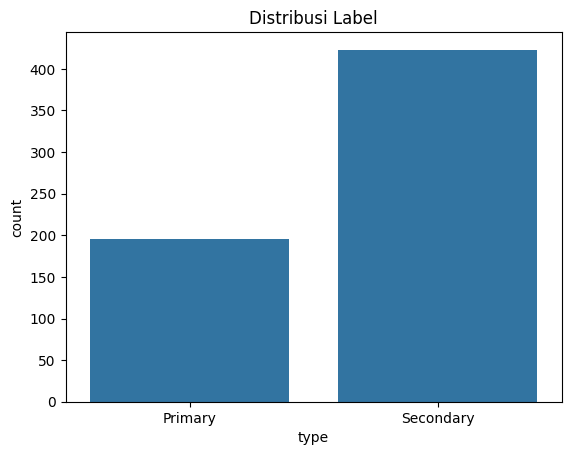

In [7]:
# Distribusi label
sns.countplot(x='type', data=df)
plt.title("Distribusi Label")
plt.show()

In [8]:
# Inisialisasi Tokenizer dari Hugging Face
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Ekstrak teks dan label dari DataFrame
texts = df['body'].fillna("").tolist()
labels = df['label'].tolist()

# Bagi data menjadi set pelatihan dan validasi sebelum tokenisasi
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Lakukan tokenisasi pada set pelatihan dan validasi secara terpisah
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512, return_tensors='pt')

In [9]:
from torch.utils.data import Dataset
import torch

class NewsDataset(Dataset):
    def __init__(self, encodings, labels):  # dua garis bawah
        self.encodings = encodings
        self.labels = labels

    def __len__(self):  # dua garis bawah
        return len(self.labels)

    def __getitem__(self, idx):  # dua garis bawah
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [10]:
train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset = NewsDataset(val_encodings, val_labels)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [11]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = AdamW(model.parameters(), lr=2e-5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [12]:
model.train()

for epoch in range(3):  
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
    print(f"Epoch {epoch + 1} - Loss: {total_loss:.4f}")


c:\Users\LOQ\UAS_DML_KELOMPOK-A\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch 1 - Loss: 32.4487
Epoch 2 - Loss: 18.2463
Epoch 3 - Loss: 14.4327


In [13]:
from sklearn.metrics import classification_report

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [14]:
print(classification_report(all_labels, all_preds, target_names=["Primary", "Secondary"]))


              precision    recall  f1-score   support

     Primary       0.58      0.85      0.69        39
   Secondary       0.91      0.72      0.80        85

    accuracy                           0.76       124
   macro avg       0.74      0.78      0.75       124
weighted avg       0.81      0.76      0.77       124



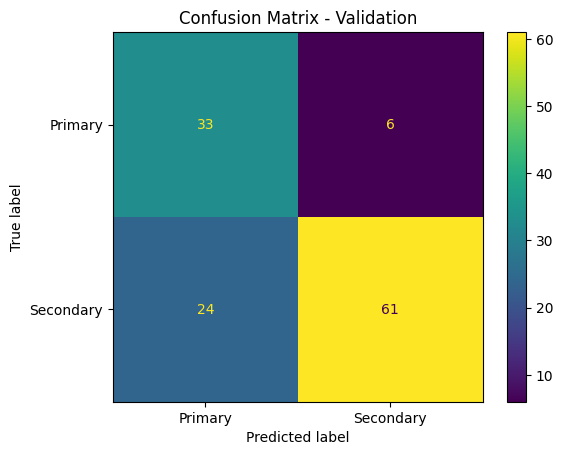

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(all_labels, all_preds, display_labels=["Primary", "Secondary"])
plt.title("Confusion Matrix - Validation")
plt.show()


In [17]:
df_test = pd.read_csv("parsed_articles_train_clean.csv")
texts_test = df_test['body'].fillna("").tolist()

test_encodings = tokenizer(texts_test, truncation=True, padding=True, max_length=512, return_tensors='pt')


In [18]:
test_dataset = NewsDataset(test_encodings, [0]*len(texts_test))  # dummy label
test_loader = DataLoader(test_dataset, batch_size=8)


In [19]:
model.eval()
test_preds = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        test_preds.extend(preds.cpu().numpy())


c:\Users\LOQ\UAS_DML_KELOMPOK-A\.venv\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [20]:
df_test['label'] = test_preds
df_test[['article_id', 'label']].to_csv("submission.csv", index=False)
print("✅ Hasil prediksi disimpan di submission.csv")


✅ Hasil prediksi disimpan di submission.csv


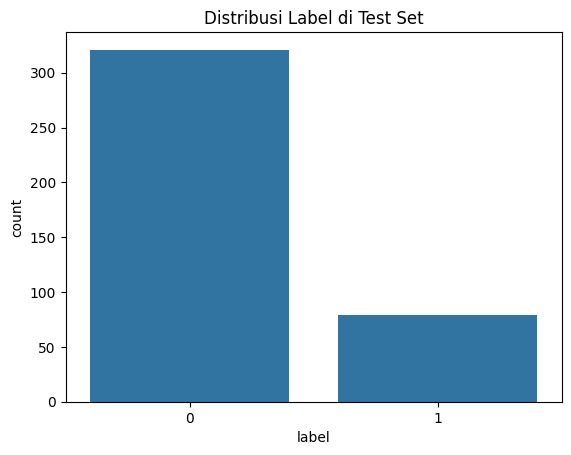

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df_test['label'])
plt.title("Distribusi Label di Test Set")
plt.show()


In [22]:
model.save_pretrained("bert_classification_model/")
tokenizer.save_pretrained("bert_classification_model/")


('bert_classification_model/tokenizer_config.json',
 'bert_classification_model/special_tokens_map.json',
 'bert_classification_model/vocab.txt',
 'bert_classification_model/added_tokens.json')

In [23]:
df_sub = pd.read_csv("submission.csv")
print(df_sub['label'].value_counts())
print("Jumlah baris:", len(df_sub))
print("Duplikat?", df_sub.duplicated(subset="article_id").any())


label
0    321
1     79
Name: count, dtype: int64
Jumlah baris: 400
Duplikat? False


In [24]:
df = pd.read_csv("submission.csv")
assert 'article_id' in df.columns and 'label' in df.columns
assert df['label'].isin([0,1]).all()


In [25]:
df.to_csv("submission_final.csv", index=False)
